## setup and notebook configuration

In [1]:
import numpy as np

In [2]:
# matplotlib, plotting setup
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns                       # nice plotting defaults
import cmocean as cmo                       # ocean colormaps
sns.set()
%matplotlib inline
#%config InlineBackend.figure_format = 'svg'

/Users/corbin/virtual_envs/FEMexperiment_env/lib/python3.6/site-packages/cmocean/tools.py:76: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not mpl.cbook.is_string_like(rgbin[0]):


In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
# local imports
import src.fem_base.master.master_1D as M1D
import src.handlers.dof_handler_1D as DOFH
import src.msh.mesh_1D as MSH
import src.fem_maps.fem_map as MAP

# problem statement

We consider the linear scalar wave equation

\begin{align}
    \frac{\partial u}{\partial t} + \frac{\partial f(u)}{\partial x} = 0, \qquad x\in\Omega
\end{align}

where we choose a linear flux $f(u) = au$ for some $a$.

# semi-discrete scheme

Considering the "weak" DG-FEM form,  we have the semi-discrete element local equation

\begin{align}
    \int_K \frac{\partial u_h}{\partial t} v \, dK
    +\int_{K} (au_h) \frac{\partial v}{\partial x} \, dK = 
    -\int_{\partial K} \hat{n}\cdot \widehat{au} v \, d\partial K
\end{align}

Choosing a representation $u=u_i\phi_i$ piecewise polynomial over each element, and the same test space, we have, for a given choice of numerical flux $\widehat{au}$, and noting that in 1D, the normal vectors on the element interior are are simply $n^- =(-1, +1)$:

\begin{align}
    \int_K \frac{\partial}{\partial t} (u_i(t) \phi_i(x)) \phi_j(x) \, dx
    +\int_{K} a(u_i(t)\phi_i(x)) \frac{\partial \phi_j(x)}{\partial x} \, dx = 
    -(\widehat{au}(x_R) - \widehat{au}(x_L))
\end{align}

transforming the integrals to the reference element:

\begin{align}
    \int_{\hat{K}} \frac{\partial}{\partial t} (u_i(t) \phi_i(\xi)) \phi_j(\xi) \,|det(J)|\, d\xi
    +\int_{\hat{K}} a(u_i(t)\phi_i(\xi)) \frac{\partial \phi_j(\xi)}{\partial \xi} \, |det(J)|\, d\xi = 
    -(\widehat{au}(x_R) - \widehat{au}(x_L))
\end{align}

This completes the description of the semi-discrete scheme, and we have a choice as to how to compute these integrals. The important part is that since the coefficients $u_i$ vary in time but are constants with respect to space, we can write 

\begin{align}
    &\frac{\partial u_i(t)}{\partial t} \int_{\hat{K}} \phi_i(\xi) \phi_j(\xi) \,|det(J)|\, d\xi
    +au_i\int_{\hat{K}} \phi_i(\xi) \left(\frac{d\xi}{dx}\right)\frac{\partial \phi_j(\xi)}{\partial \xi} \, |det(J)|\, d\xi = 
    -(\widehat{au}(x_R) - \widehat{au}(x_L)) \\
   &\Rightarrow M_K \vec{\frac{du_h}{dt}} + a  S_K \vec{u_h} 
   = - L\, (\widehat{au}(x_R) - \widehat{au}(x_L))
\end{align}

Where we have computed $M_K$ and $S_K$, the mass and stiffness matrices for element $K$. Although we would normally do this with a quadrature rule, we can take advantage of the fact that in 1D (and indeed under any affine mapping from reference to physical element), $J^{-1}$ and $|\det(J)|$ will be constant over the entire element (also note that in 1D, $J^{-1}$ is a 1x1 matrix)<sup>1</sup>. In that case, we can treat both as constants, precompute $M_{\hat{K}}, S_{\hat{K}}$, and multiply the entire element-local equation by $M^{-1}$, giving

\begin{align}
\vec{\frac{du_h}{dt}} &= - a \frac{\det(J)_K}{\det(J)_K}\, J^{-1}_K M_{\hat{K}}^{-1}S^T_{\hat{K}} \vec{u_h} 
  - \frac{1}{\det(J)_K} M^{-1}_K L\, (\widehat{au}(x_R) - \widehat{au}(x_L)) \\
  &= - a \, J^{-1}_K M_{\hat{K}}^{-1}S^T_{\hat{K}} \vec{u_h} 
  - \frac{1}{\det(J)_K} M^{-1}_K L\, (n^- \widehat{au}(x_R) - n^-\widehat{au}(x_L))
\end{align}

Which is a good form for a black box integrator, since we have a "naked" $\frac{du_h}{dt}$, and because the scheme is explicit.

note<sup>1</sup>: $J, J^{-1}$ are 1x1 matrices, and $\det{J}$ is simply $J_{11}$; $J^{-1} = 1/J_{11}$. It's important for the clarity of explicit schemes to understand where these cancellations occur.

# numeric implementation

In [5]:
# global constants
π = np.pi

## driver

In [6]:
# Low storage Runge-Kutta coefficients LSERK
rk4a = np.array([
         0.0,
        -567301805773.0/1357537059087.0,
        -2404267990393.0/2016746695238.0,
        -3550918686646.0/2091501179385.0,
        -1275806237668.0/842570457699.0])

rk4b = np.array([ 
         1432997174477.0/9575080441755.0,
         5161836677717.0/13612068292357.0,
         1720146321549.0/2090206949498.0,
         3134564353537.0/4481467310338.0,
         2277821191437.0/14882151754819.0])

rk4c = np.array([
         0.0,
         1432997174477.0/9575080441755.0,
         2526269341429.0/6820363962896.0,
         2006345519317.0/3224310063776.0,
         2802321613138.0/2924317926251.0])

In [7]:
def compute_interior_flux(u, norm, dofh, a, α):
    """ computes the numerical flux at all of the element interfaces
    @param u  the current solution u, dgnodes form
    NOTE: boundary interfaces will be filled with garbage, and must be corrected
    """
    pm = dofh.lg_PM
    ur = u.ravel(order='F')
    nr = norm.ravel(order='F')
    print('ur {}'.format(ur))
    print('nr {}'.format(nr))
    
    # equivalent to the flux
    #  \hat{au} = {{au}} + (1-α) * |a|/2 * [[u]]
    # at element interfaces. First and last interface will have garbage.
    print('\t computing fluxes')
    print('\t u+ {}'.format(ur[pm['+']]))
    print('\t u- {}'.format(ur[pm['-']]))
    print('norm shape {}'.format(norm.shape))
    flux = a/2*(ur[pm['-']] + ur[pm['+']]) + (1-α)*np.abs(a)/2.*nr*(ur[pm['-']] - ur[pm['+']] )
    
    flux = flux.reshape(norm.shape, order='F')
    print('reshaped flux {}'.format(flux))
    return flux

Note that the jump and average operators are defined on the element edge space (red space). The flux is a quantity that is intrinsically defined from 

In [21]:
def advect_rhs_1D(u, t_local, a, master, _map, dofh, flux_fn, gD, normals):
    
    Minv, S, L = master.Minv, master.S, master.L
    Jinv = _map.Jinv[0][:,0,0,:]
    detJ = _map._detJ[0]

    print('u advect start')
    print(u)
    # interior fluxes
    elm_edge_flux = flux_fn(u, normals, dofh, a, α=0)

    # compute boundary fluxes
    elm_edge_flux[0, 0] = gD(t_local)
    print('gD')
    print(gD(t_local))
    elm_edge_flux[-1, -1] = gD(t_local)
    
    print('flux on edge, {}'.format(elm_edge_flux.shape))
    print(elm_edge_flux)
    print('normals, {}'.format(normals.shape))
    print(normals)    
    #elm_edge_flux *= normals
    print('dotted flux')
    print(elm_edge_flux)
    
    # elm edge flux on left negated 
    #elm_edge_flux[0,:] *= -1

    # pull fluxes to element edge space
    #int_flux_elm_edge = dofh.edge2elm_ed(flux_on_edge)

    # don't need to scale faces
    print(np.dot(L, elm_edge_flux))
    edge_int = -1./detJ * np.dot(Minv, np.dot(L, elm_edge_flux))
    int_int = +a * Jinv * np.dot(Minv, np.dot(S, u))
    RHS = int_int + edge_int
    
    return RHS

## problem discretization

In [26]:
p = 1
n_elm = 30
mesh = MSH.Mesh1D(P=np.linspace(0, 2*π, n_elm+1))
master = M1D.Master1D(p=p)
dofh = DOFH.DG_DOFHandler1D(mesh, master)

# temporary adapter to mesh
mapdgn = np.zeros((dofh.dgnodes.shape[0], 1, dofh.dgnodes.shape[1]))
mapdgn[:,0,:] = dofh.dgnodes
_map = MAP.Isoparametric_Mapping(master=[master], dgnodes=[mapdgn], map_nodes='NODAL')

set up the problem

In [27]:
# final time
T = 10

# compute time step size, irrelevant for backward euler
CFL = 0.75
Δx = dofh.dgnodes[1,0] - dofh.dgnodes[0,0]
Δt = CFL/(2*π)*Δx
Δt = Δt / 10

# number of timesteps needed
steps = int(np.ceil(T/Δt))

# initial condition, advection speed
solution = np.zeros((steps, *dofh.dgnodes.shape))
a = 2 * π
solution[0,::] = np.sin(dofh.dgnodes)

LSERK_stages = [0, 1, 2, 3, 4]
t = 0

gD = lambda t: np.sin(a*t)

# normal vectors, all positive
norm = np.ones((2, dofh.nElm))
norm[0,:] *= -1

# function pointer to something that can compute fluxes
flux_fn = compute_interior_flux

In [28]:
# simple time loop
print('Δt = {}'.format(Δt))
print('PM = {}'.format(dofh.lg_PM))
RK_resid = np.zeros_like(dofh.dgnodes)
for tstep in range(20):
    u = np.copy(solution[tstep, ::])
    rhsu = advect_rhs_1D(u, t, a, master, _map, dofh, flux_fn, gD, norm)
    u += Δt * rhsu
    t += Δt
    tstep += 1
    solution[tstep, :,:] = u

Δt = 0.0024999999999999996
PM = {'-': array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59]), '+': array([ 0,  2,  1,  4,  3,  6,  5,  8,  7, 10,  9, 12, 11, 14, 13, 16, 15,
       18, 17, 20, 19, 22, 21, 24, 23, 26, 25, 28, 27, 30, 29, 32, 31, 34,
       33, 36, 35, 38, 37, 40, 39, 42, 41, 44, 43, 46, 45, 48, 47, 50, 49,
       52, 51, 54, 53, 56, 55, 58, 57, 59])}
u advect start
[[ 0.00000000e+00  2.07911691e-01  4.06736643e-01  5.87785252e-01
   7.43144825e-01  8.66025404e-01  9.51056516e-01  9.94521895e-01
   9.94521895e-01  9.51056516e-01  8.66025404e-01  7.43144825e-01
   5.87785252e-01  4.06736643e-01  2.07911691e-01  1.22464680e-16
  -2.07911691e-01 -4.06736643e-01 -5.87785252e-01 -7.43144825e-01
  -8.66025404e-01 -9.51056516e-01 -9.94521895e-01 -9.94521895e-01
  -9.5

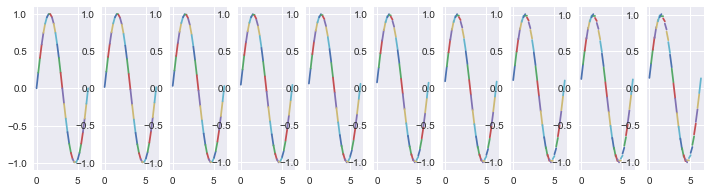

In [29]:
Nplots = 10
fig = plt.figure(figsize=(12, 3))
for i in range(Nplots):
    u = solution[i,:,:]
    ax = fig.add_subplot(1, Nplots, i+1)
    ax = plot_solution(ax, u, dofh)


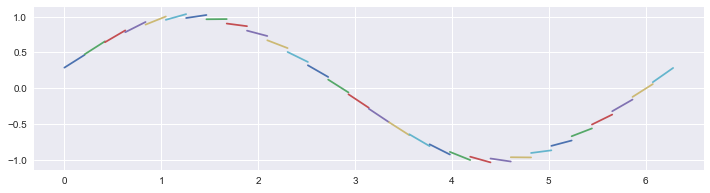

In [31]:
Nplots = 10
fig = plt.figure(figsize=(12, 3))
i=19
u = solution[i,:,:]
ax = fig.add_subplot(1,1, 1)
ax = plot_solution(ax, u, dofh)

In [14]:
def plot_solution(ax, u, dofh):
    """ u formatted like dgnodes """
    for elm in range(dofh.nElm):
        nodal_pts = dofh.dgnodes[:, elm]
        nodal_values = u[:, elm]
        
        ax.plot(nodal_pts, nodal_values)
    return ax

In [ ]:
# time loop
print(solution.shape)
RK_resid = np.zeros_like(dofh.dgnodes)
for tstep in range(10):
    u = np.copy(solution[tstep, ::])
    print(u)
    for s in LSERK_stages:
        t_local = t + rk4c[s]*Δt
        rhsu = advect_rhs_1D(u, t_local, a, master, _map, dofh, flux_fn, gD, norm)
        RK_resid = rk4a[s]*RK_resid + Δt*rhsu
        u += rk4b[s]*RK_resid
    t += Δt
    tstep += 1
    solution[tstep, :,:] = u